# Time Series in Python
# Practical approach
# Homework task

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline



from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

В этой домашней работе вам предстоит поработать с двумя временными рядами, один - уже знакомый ряд с тратой внутриигровой валюты `currency`, второй - установки по дням в одном из наших приложений, `installs`

In [3]:
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])
installs = pd.read_csv('data/installs.csv', index_col=['Time'], parse_dates=['Time'])

Снова посмотрим на графики временных рядов

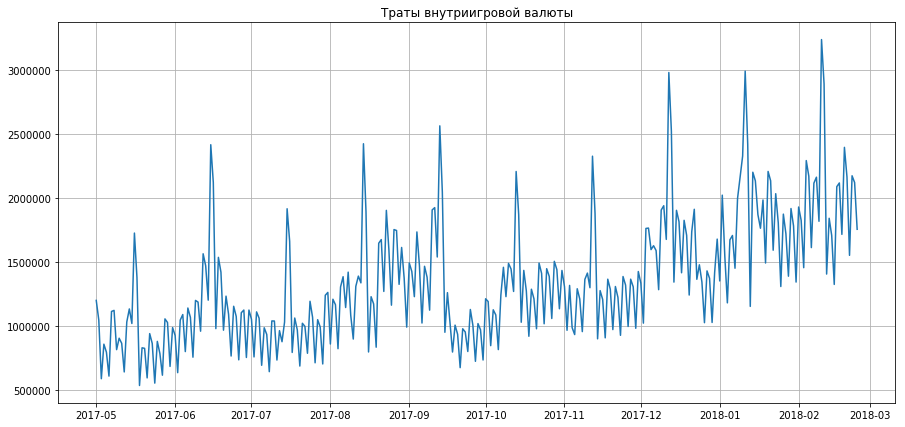

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

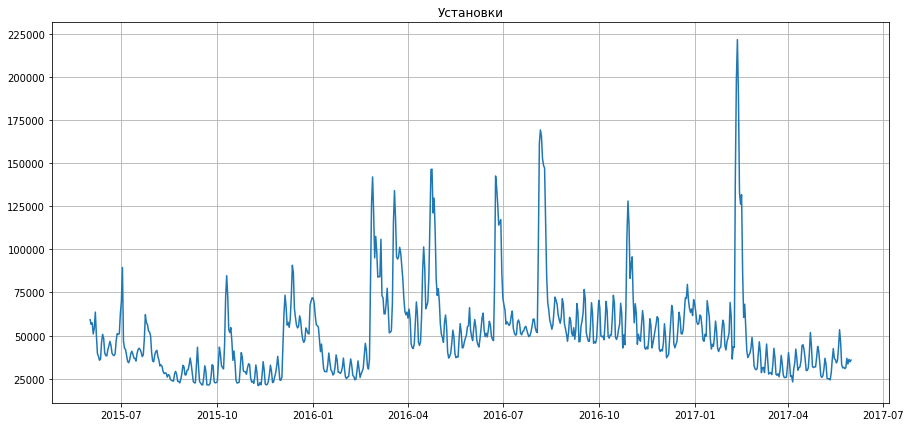

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(installs)
plt.title('Установки')
plt.grid(True)
plt.show()

У первого временного ряда явно есть и сезонность, и тренд, а вот второй ряд с установками имеет очень много выбросов, которые никак не характеризуются сезонными изменениями.

Для начала поработаем с моделью тройного экспоненциального сглаживания - моделью Хольта-Винтерса

In [60]:
from sklearn.model_selection import TimeSeriesSplit 
# from HoltWinters import HoltWinters                 
class HoltWinters:
    
    """
        Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
        https://fedcsis.org/proceedings/2012/pliks/118.pdf
        
        
        # series - исходный временной ряд
        # slen - длина сезона
        # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
        # n_preds - горизонт предсказаний
        # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
        
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i] / season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, 'b',label = "Model")
    plt.plot(series.values, 'y', label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-50, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

Задание:

- Построить модель для временного ряда с установками, используя `mean_squared_error` в качестве функции потерь
- Сначала постройте модель на всём ряду installs.Users, отложив только последние 50 наблюдений для тестирования, убедитесь, что прогноз по такой модели будет сильно заниженным
- Теперь возьмите для моделирования только последние 500 наблюдений, для этого возьмите от временного ряда срез [500:-50], чтобы учесть в модели только последние изменения и не пытаться подогнать параметры под историю, которая уже стала нерелевантной

Так как процедура minimize тяготет к локальным минимумам, нужно аккуратно подбирать начальные значение x0

при нулевом начальном векторе ошибка модели >50%

при х=[0.1,0.01,0.1] ошибка опускалась до 15%

смещение в [0.5,0.01,0.5] дает резкое уменьшение ошибки (до 2%), но снижение доверительных интервалов говорит о сильном переобучении, что подтверждается большим количеством выбросов в конце ряда Этот начальный вектор по сути - граничное значение (точка бифуркации) модели, причем это происходит и для ограниченного датасета [500:]

для начального вектора [0.4,0.01,0.4] результат становится приемлемым, хотя ошибка все равно около 13.5, но в тестовой выборке - большое число выбросов.


In [62]:
%%time
data = installs.Users[:-50] # отложим 50 наблюдений для тестирования
slen = 7 # недельная сезонность
# инициализируем значения параметров
x = [0.4, 0.01, 0.4] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.10119652744774049 0.03618988857770877 0.4007242440557725
CPU times: user 11.8 s, sys: 77.7 ms, total: 11.9 s
Wall time: 12 s


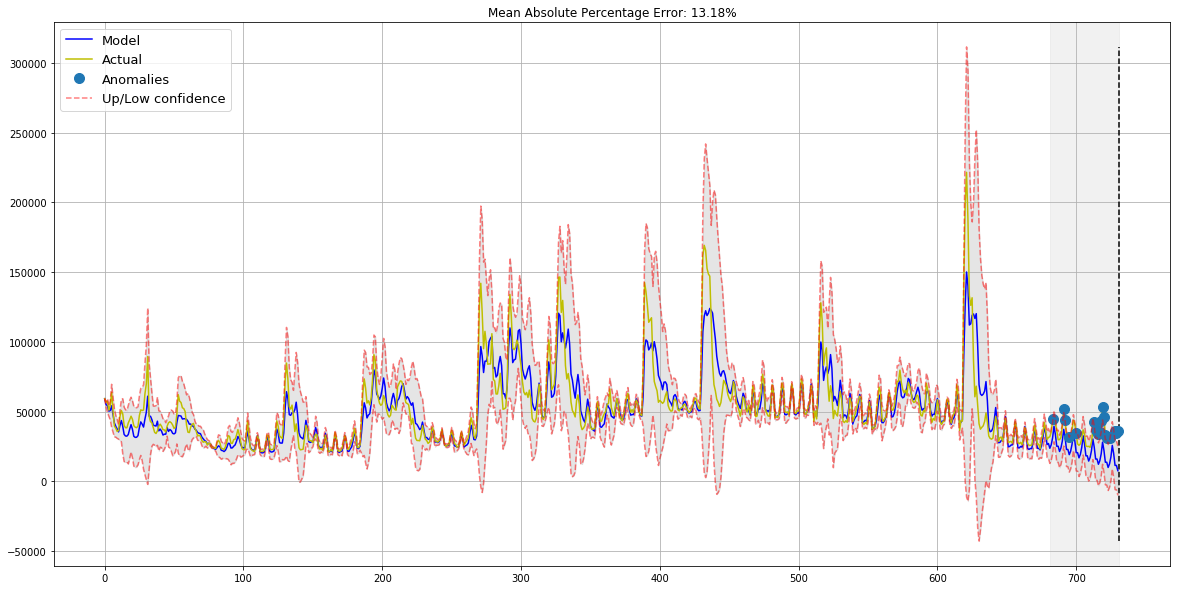

In [63]:
plotHoltWinters(installs.Users, plot_intervals=True, plot_anomalies=True)

А теперь обрежем наши данные, чтобы обучаться на последнем промежутке времени, наиболее релевантным для сегодняшних значений

In [64]:
%%time
data = installs.Users[500:-50] 
slen = 7 # ?

x = [0.4, 0, 0.4] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.2341860699297698 0.024309962962421827 0.12080153660793869
CPU times: user 3.54 s, sys: 33.7 ms, total: 3.58 s
Wall time: 3.62 s


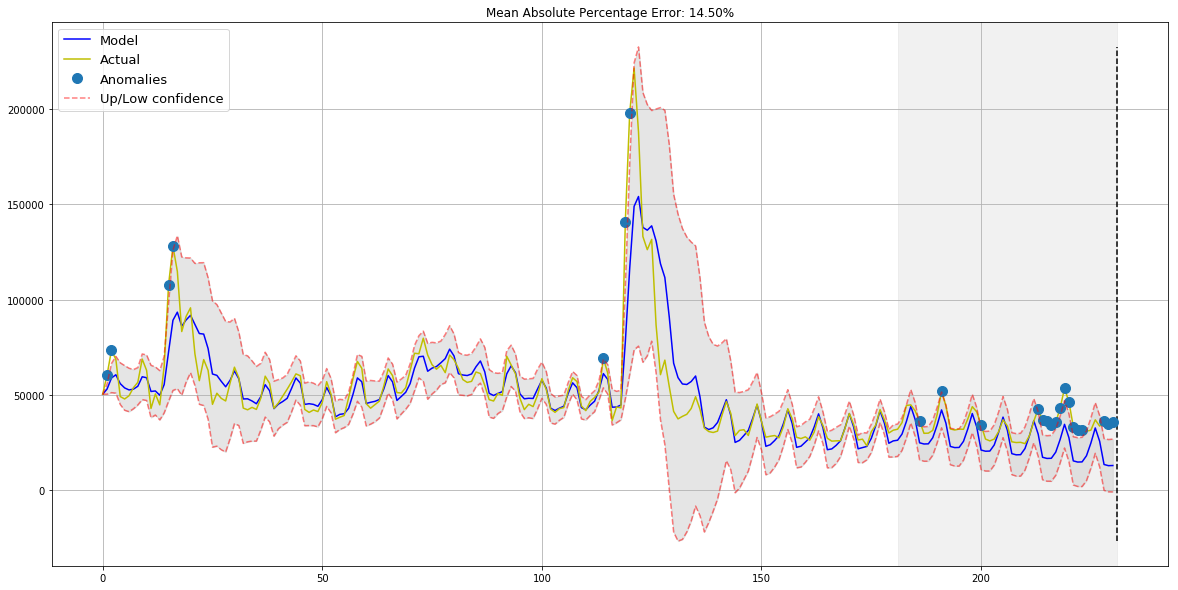

In [65]:
plotHoltWinters(installs.Users[500:], plot_intervals=True, plot_anomalies=True)

Прекрасно! Мы снова можем ловить аномалии, а модель неплохо описывает поведение нашего временного ряда и строит правдоподобный прогноз

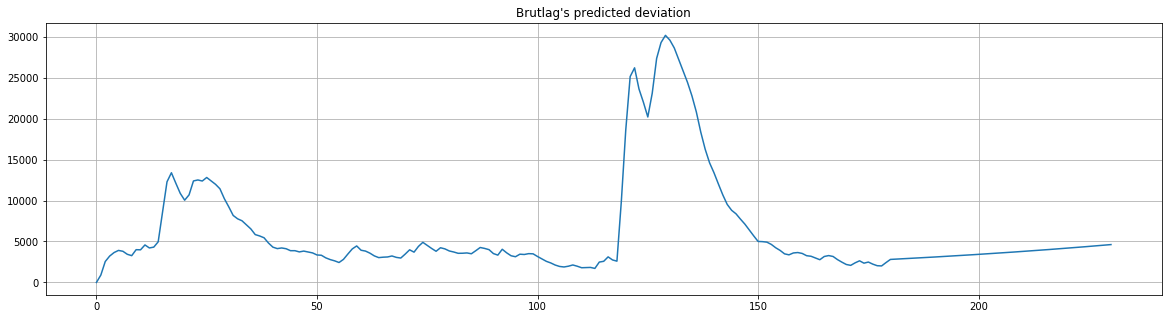

In [66]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

По графику смоделированной дисперсии легко увидеть, как выброс в наших данных значительно увеличил отклонение и вызвал расширение доверительных интерваловна некоторых промежуток времени

# Эконометрический подход

In [67]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [77]:
def optimizeSARIMA(series_,parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(series_, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [69]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

В качестве домашнего задания и хорошей практики для закрепления - по аналогии с лекцией построить модель SARIMA для прогнозирования временного ряда с тратой внутриигровой валюты, в котором присутствует тренд (убирается при помощи первых разностей) и месячная сезонность (сезонное дифференцирование с периодом 30)

Критерий Дики-Фуллера: p=0.372542


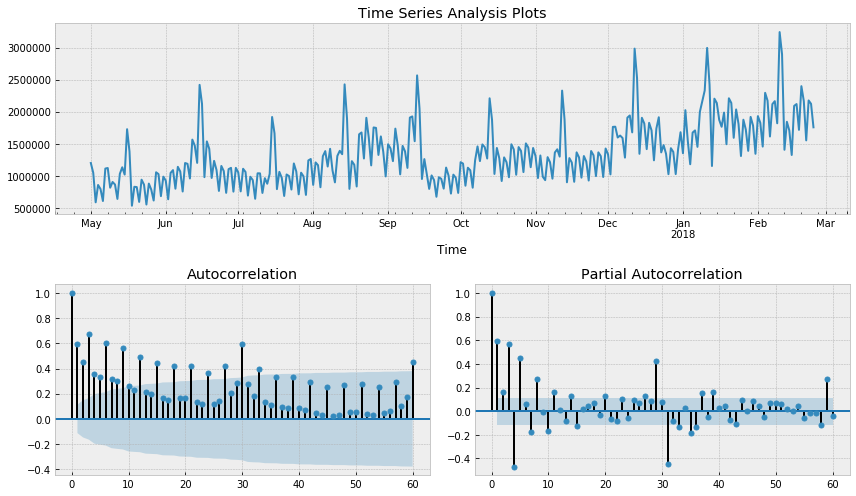

In [70]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

# TODO
# - привести ряд к стационарному виду
# - по ACF, PACF определить начальные значения параметров модели и возможные интервалы
# - перебором параметров подобрать оптимальную модель и построить её
# - построить график модельных значений и остатков, убедиться в адекватности результатов

In [71]:
currency_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(30)

Критерий Дики-Фуллера: p=0.002438


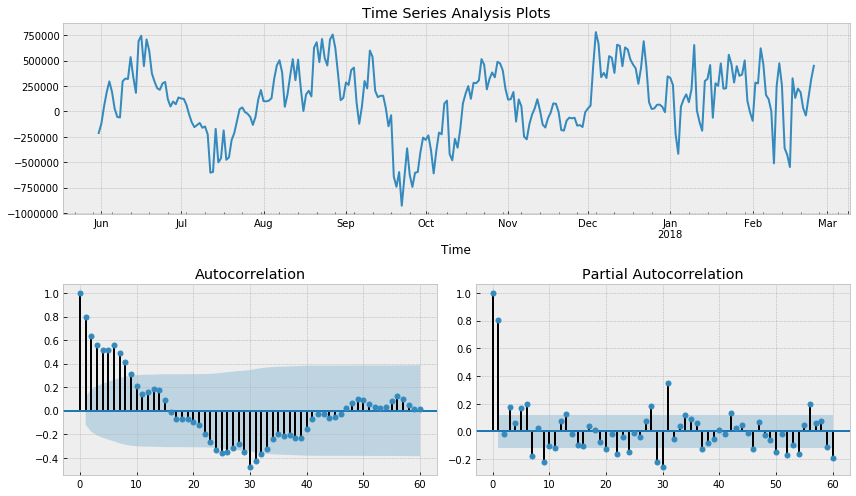

In [73]:
tsplot(currency_diff[30:], lags=60)

Критерий Дики-Фуллера: p=0.000061


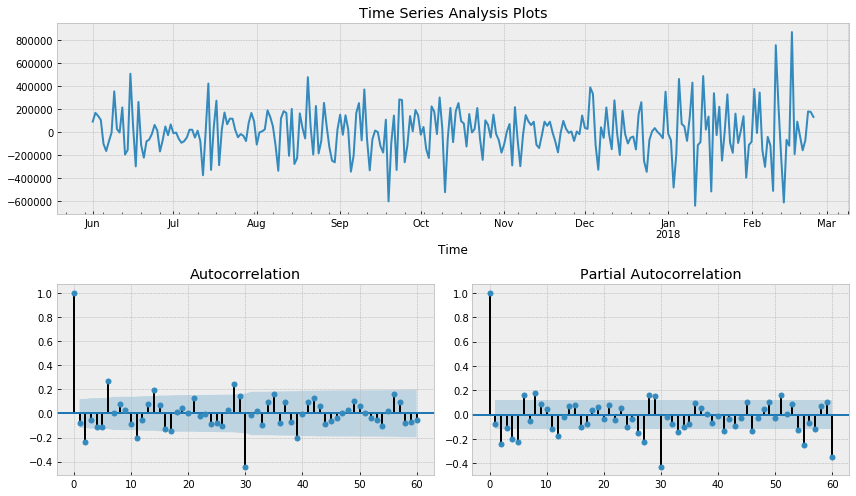

In [74]:
currency_diff = currency_diff - currency_diff.shift(1)
tsplot(currency_diff[31:], lags=60)

In [75]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(7, 12) #p=10
d= 1
qs = range(4, 8) #q=6

Ps = range(0, 3) #Ps=2
D= 1
Qs = range(0, 2) #Qs=1
s = 30

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

In [78]:
%%time
result_table = optimizeSARIMA(currency.GEMS_GEMS_SPENT,parameters_list, d, D, s)


CPU times: user 8min 59s, sys: 3.8 s, total: 9min 3s
Wall time: 4min 37s


In [79]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(8, 1, 7)x(0, 1, 1, 30)   Log Likelihood               -3603.901
Date:                            Fri, 07 Dec 2018   AIC                           7241.801
Time:                                    03:27:32   BIC                           7302.911
Sample:                                05-01-2017   HQIC                          7266.343
                                     - 02-24-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9653      1.042      0.926      0.354      -1.077       3.008
ar.L2         -1.1038      1.100   

Критерий Дики-Фуллера: p=0.000000


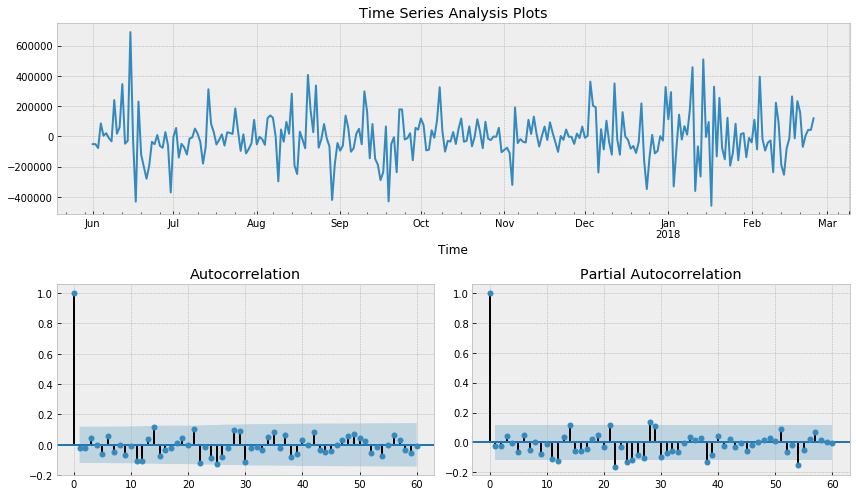

In [80]:
tsplot(best_model.resid[31:], lags=60)

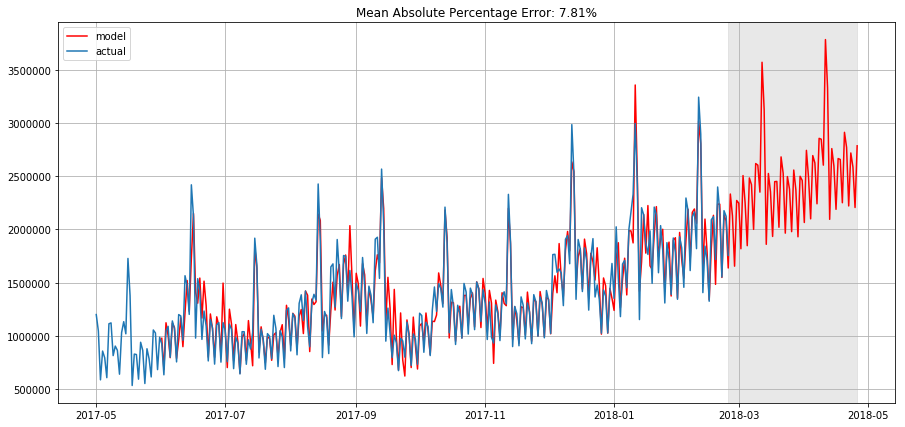

In [82]:
plotSARIMA(currency, best_model,60)

# Machine Learning для временных рядов

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

scaler = StandardScaler()
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [86]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [181]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, diff=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    if diff:
        prediction=prediction+trend_test
 
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, 'r', label="actual", linewidth=2.0)
        
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "o--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "o--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [88]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [96]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
#     data.index = data.index.to_datetime()
    data["monthday"] = data.index.day
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["monthday_average"] = list(map(code_mean(data[:test_index], 'monthday', "y").get, data.monthday))

        # выкидываем закодированные средними признаки 
        data.drop(["monthday", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

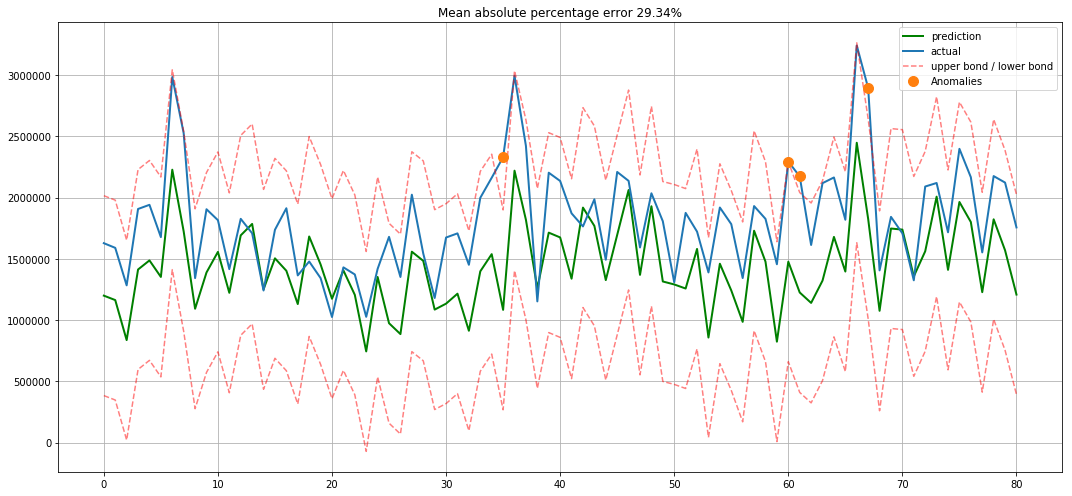

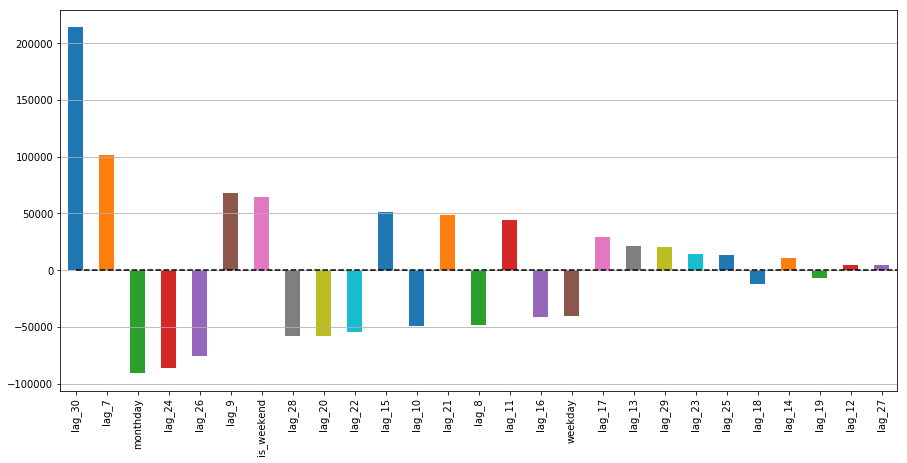

In [97]:
# без кодирования средним
X_train, X_test, y_train, y_test =\
prepareData(currency, lag_start=7, lag_end=31, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

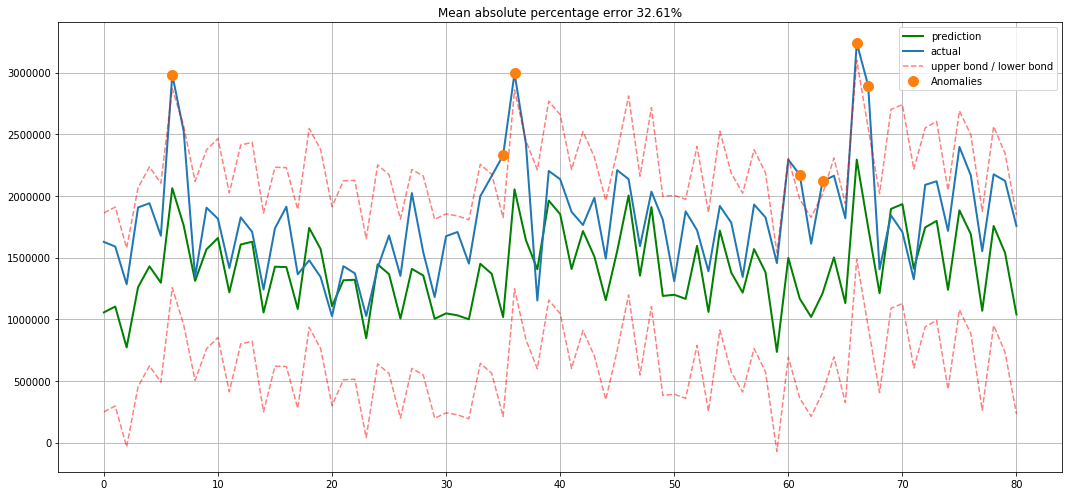

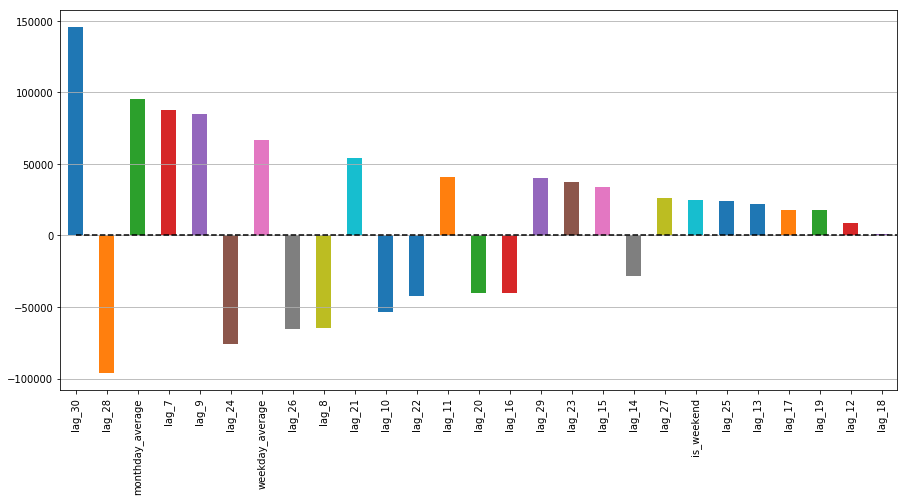

In [98]:
#с кодированием средним
X_train, X_test, y_train, y_test =\
prepareData(currency, lag_start=7, lag_end=31, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

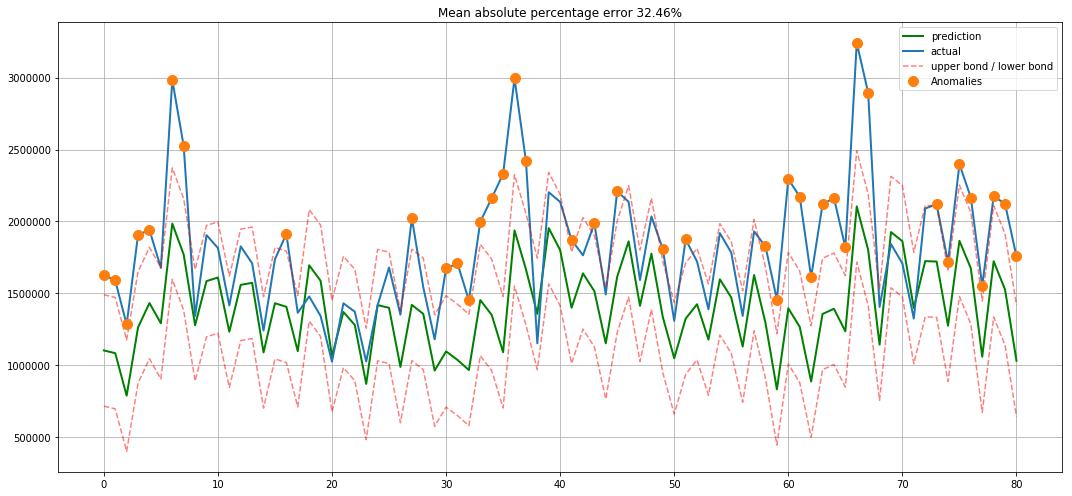

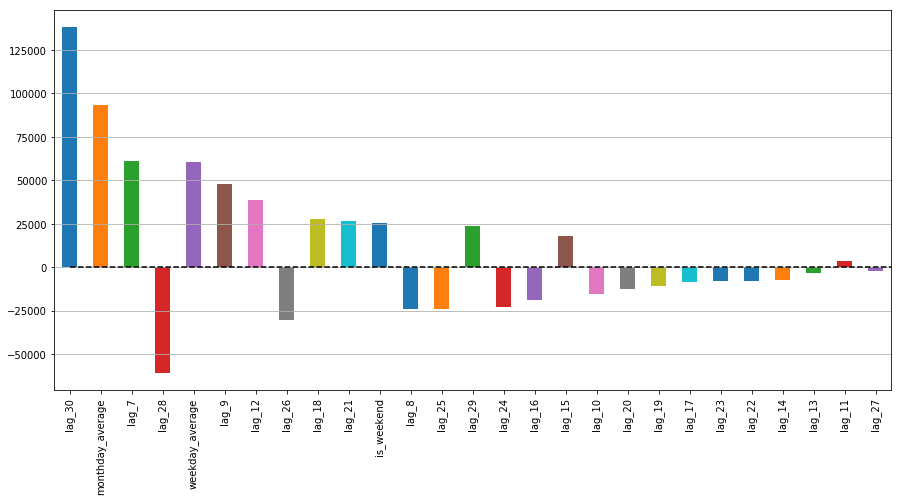

In [103]:
# L2 регуляризация
from sklearn.linear_model import LassoCV, RidgeCV
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True,
                plot_anomalies=True)

plotCoefficients(ridge)

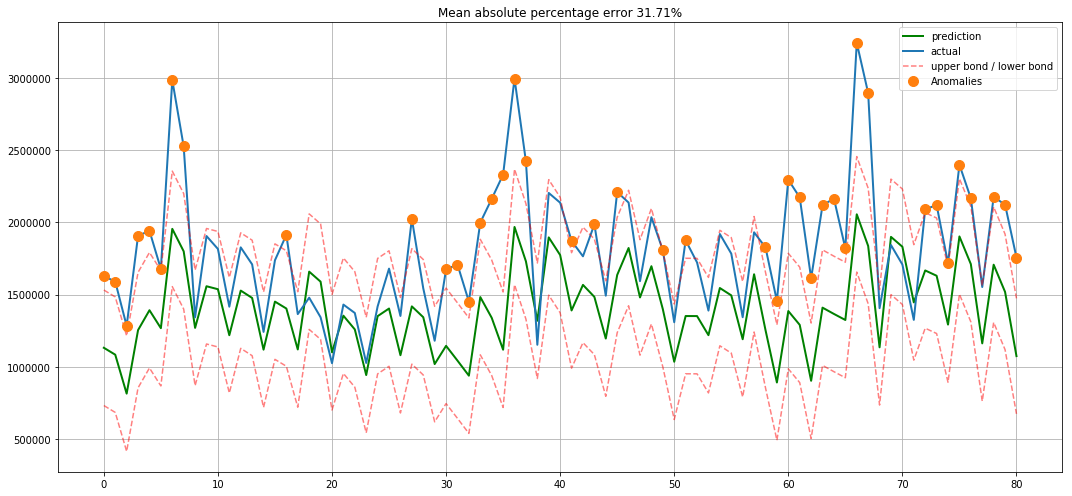

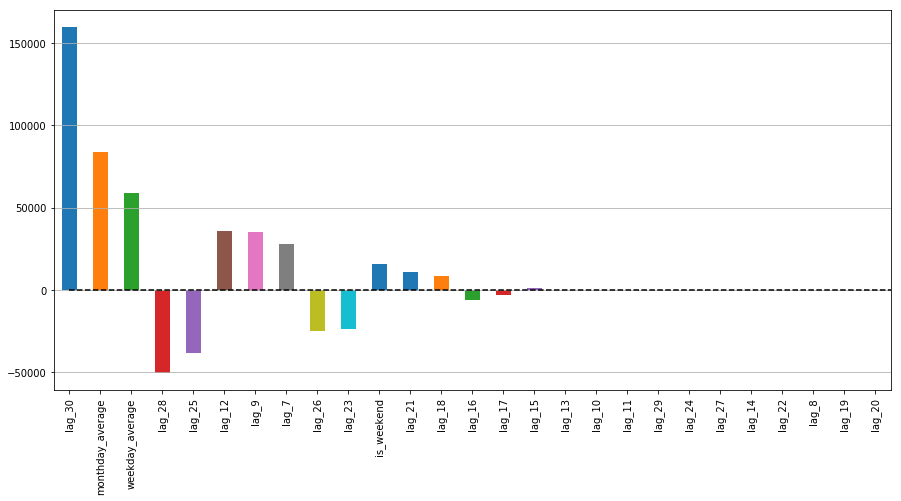

In [102]:
# L1 регуляризация - плохо работает
ridge = LassoCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True,
                plot_anomalies=True)
plotCoefficients(ridge)

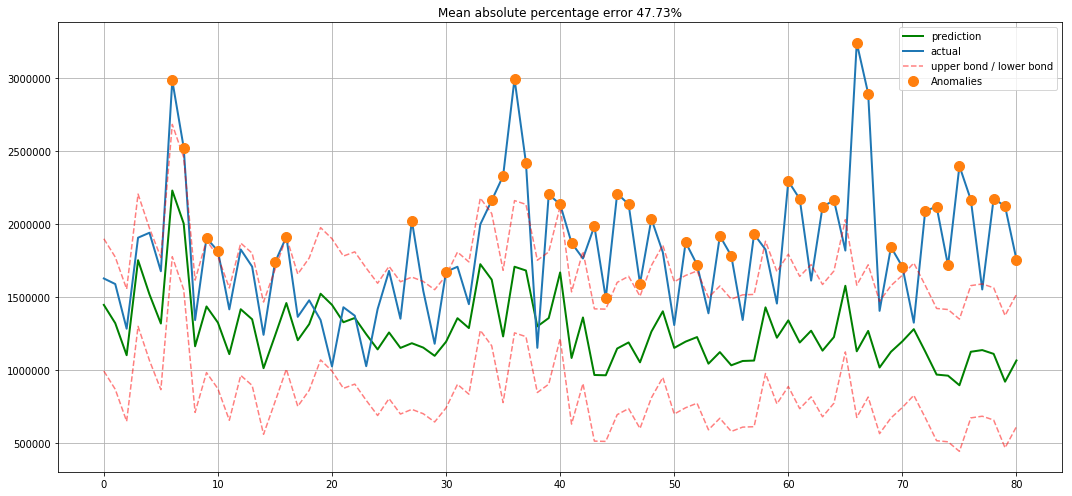

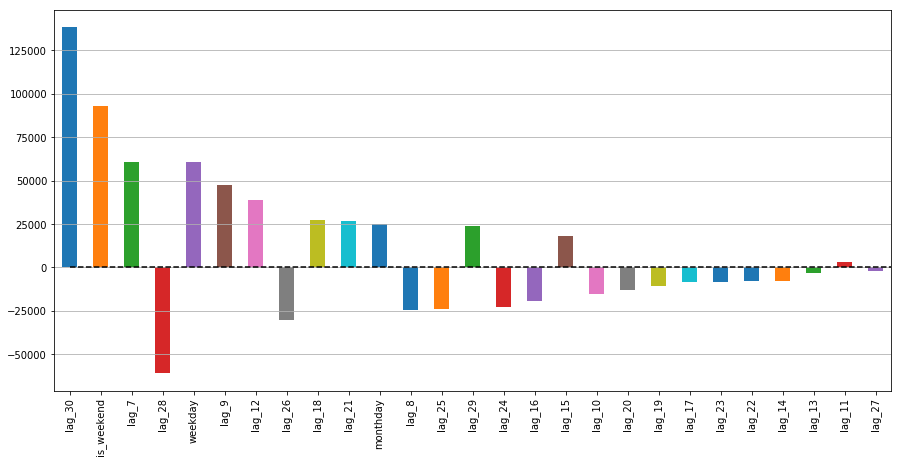

In [155]:
# Бустинг. Все очень плохо....
from xgboost import XGBRegressor 
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True,
                plot_anomalies=True)

plotCoefficients(ridge)

Снова небольшим домашним заданием будет построение моделей для временного ряда с внутриигровой валютой.

TODO

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"
- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше
- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат

Крутое бонус-задание
- Разбейте подготовленные данные на `train` и `test`
- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))
- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза
- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`
- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

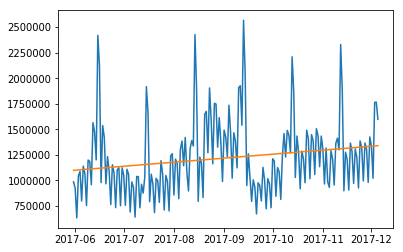

In [193]:
# разбиваем на train и test, нормируем
X_train, X_test, y_train, y_test =\
prepareData(currency, lag_start=7, lag_end=31, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# строим регрессию для y_train
X_=range(0,len(y_train))
X_=np.reshape(X_,(len(X_),1))
lr = LinearRegression()
lr.fit(X_, y_train)

# строим тренд и вычитаем его из y_train, отрисовываем
trend_train=lr.predict(X_)

plt.plot(y_train)
plt.plot(y_train.index,trend_train)
plt.show()

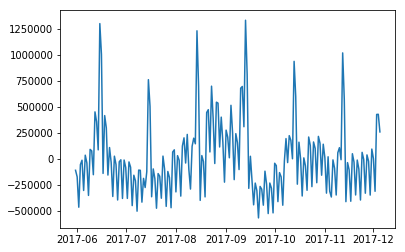

In [194]:
y_train_diff=y_train-trend
plt.plot(y_train_diff)

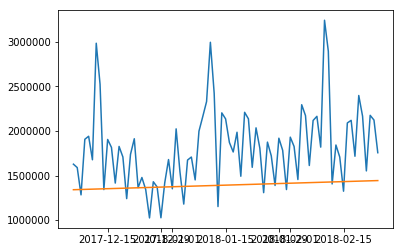

In [195]:
X__=range(len(y_train), len(y_train)+len(y_test))
X__=np.reshape(X__,(len(X__),1))

trend_test=lr.predict(X__)
y_test_diff=y_test-trend_test

plt.plot(y_test)
plt.plot(y_test.index,trend_test)
plt.show()

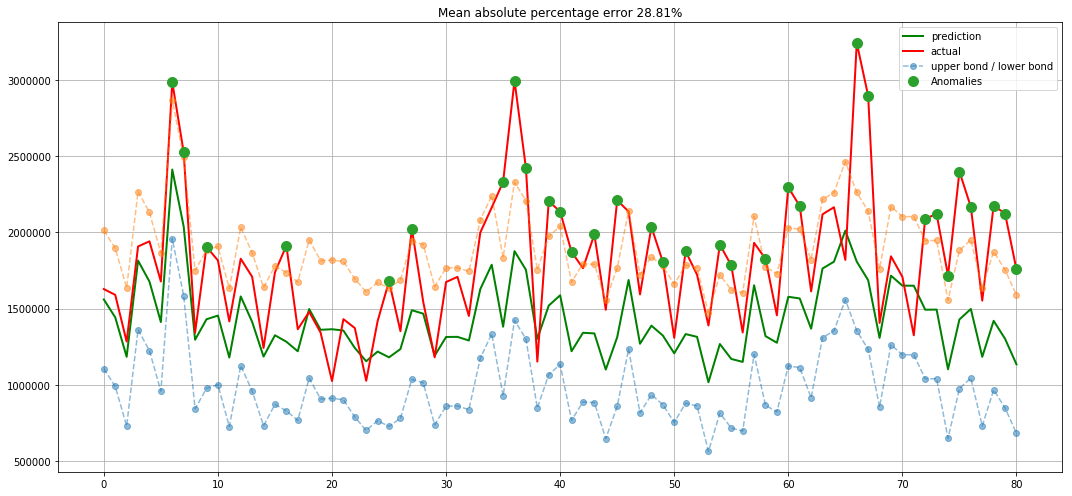

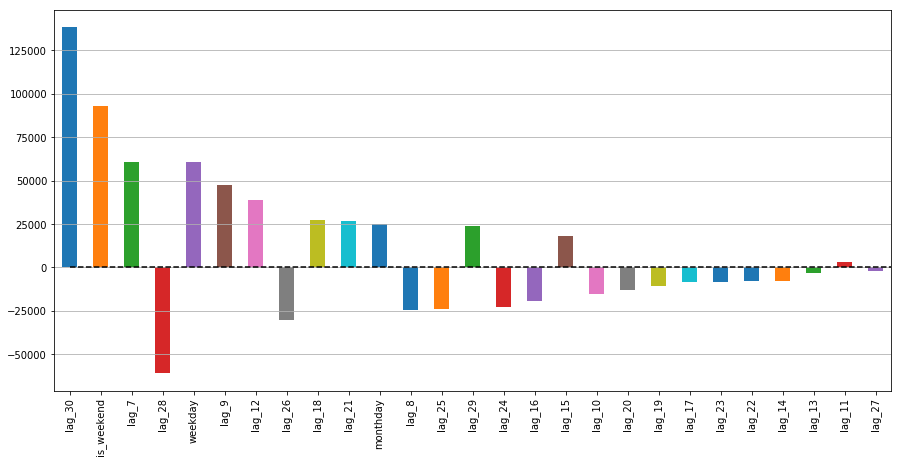

In [196]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train_diff)

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True,
                plot_anomalies=True,
                diff=True)

plotCoefficients(ridge)
# результат конечно получше (29%) но я бы на такую модель не опирался.